## 🔑 Key Benefits of Persistence

| Benefit                | Description                                                        |
|------------------------|--------------------------------------------------------------------|
| ✅ Resumable workflows | Can pause and continue long-running tasks                          |
| ✅ Short  term memory(Conversation memory) | Agents remember prior interactions (using `thread_id`)             |
| ✅ Crash recovery(Fault tolerance)      | Recover from failures without restarting from scratch              |
| ✅ Debugging(TIME TRAVEL)           | You can inspect saved intermediate states                          |
| ✅ Scalability         | Supports distributed or long-running applications                  |
| ✅ Multi-turn agents   | Necessary for chatbots, tools, and planning agents                 |
| ✅ Experiment reproducibility | Run the same thread again with saved state               |


In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict,Annotated,Literal
from dotenv import load_dotenv, find_dotenv
from pydantic import BaseModel, Field
import operator
from langchain_core.messages import SystemMessage,HumanMessage,BaseMessage
from langgraph.checkpoint.memory import MemorySaver,InMemorySaver
from langgraph.graph.message import add_messages


<b>InMemorySaver</b> is a memory-based checkpoint saver provided by langgraph — it stores all the intermediate state in RAM (i.e., system memory), not on disk or a database.


🚫 Limitation <br>
Since InMemorySaver stores everything in RAM:

❌ Data is lost when the program ends

❌ Not scalable for long-term or production use

✅ Great for testing, debugging, or short runs


In [2]:
_: bool = load_dotenv(find_dotenv())

model = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")

In [3]:
##Class State

class JokeState(TypedDict):
    topic:str
    joke:str 
    exp:str 

In [4]:
def gen_joke(state:JokeState):
    topic=state['topic']

    prompt=f"Write a joke on the topic {topic}"
    response=model.invoke(prompt).content

    return {'joke':response}

def gen_exp(state:JokeState):

    joke=state['joke']
    prompt=f"Write an explanation of this JOke {joke}"

    response=model.invoke(prompt).content

    return {'exp':response}



In [5]:
graph=StateGraph(JokeState)

graph.add_node("gen_joke",gen_joke)
graph.add_node("gen_exp",gen_exp)

graph.add_edge(START,'gen_joke')
graph.add_edge("gen_joke","gen_exp")
graph.add_edge("gen_exp",END)

checkpointer=InMemorySaver()

workflow=graph.compile(checkpointer=checkpointer)

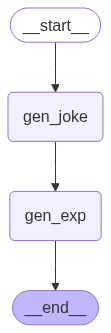

In [6]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

config1 tells LangGraph:

“This run belongs to thread ID = '1'.”

In [7]:
config1={"configurable":{"thread_id":"1"}}
workflow.invoke({'topic':'water'},config=config1)

{'topic': 'water',
 'joke': 'Why did the water break up with the ice?\n\nBecause it felt like their relationship was going nowhere!',
 'exp': 'Okay, here\'s the breakdown of the joke:\n\n*   **The Setup:** "Why did the water break up with the ice?" This sets up a scenario where we\'re anthropomorphizing water and ice, giving them a relationship.\n\n*   **The Punchline:** "Because it felt like their relationship was going nowhere!"\n\n*   **The Humor:** The humor lies in the double meaning of "going nowhere."\n\n    *   **Literal Meaning:** Ice is stationary. It doesn\'t move unless it\'s melted or pushed. So, from the water\'s perspective, the relationship is stagnant and not progressing.\n\n    *   **Figurative Meaning:** "Going nowhere" is a common idiom to describe a relationship that is not developing or heading towards a positive future.\n\nThe joke works because it cleverly combines the literal properties of water and ice with a common expression about relationships. The contrast

In [8]:
###Final state values
workflow.get_state(config1)

StateSnapshot(values={'topic': 'water', 'joke': 'Why did the water break up with the ice?\n\nBecause it felt like their relationship was going nowhere!', 'exp': 'Okay, here\'s the breakdown of the joke:\n\n*   **The Setup:** "Why did the water break up with the ice?" This sets up a scenario where we\'re anthropomorphizing water and ice, giving them a relationship.\n\n*   **The Punchline:** "Because it felt like their relationship was going nowhere!"\n\n*   **The Humor:** The humor lies in the double meaning of "going nowhere."\n\n    *   **Literal Meaning:** Ice is stationary. It doesn\'t move unless it\'s melted or pushed. So, from the water\'s perspective, the relationship is stagnant and not progressing.\n\n    *   **Figurative Meaning:** "Going nowhere" is a common idiom to describe a relationship that is not developing or heading towards a positive future.\n\nThe joke works because it cleverly combines the literal properties of water and ice with a common expression about relation

In [9]:
###Intermediate State values(Output-->down to upward)
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'water', 'joke': 'Why did the water break up with the ice?\n\nBecause it felt like their relationship was going nowhere!', 'exp': 'Okay, here\'s the breakdown of the joke:\n\n*   **The Setup:** "Why did the water break up with the ice?" This sets up a scenario where we\'re anthropomorphizing water and ice, giving them a relationship.\n\n*   **The Punchline:** "Because it felt like their relationship was going nowhere!"\n\n*   **The Humor:** The humor lies in the double meaning of "going nowhere."\n\n    *   **Literal Meaning:** Ice is stationary. It doesn\'t move unless it\'s melted or pushed. So, from the water\'s perspective, the relationship is stagnant and not progressing.\n\n    *   **Figurative Meaning:** "Going nowhere" is a common idiom to describe a relationship that is not developing or heading towards a positive future.\n\nThe joke works because it cleverly combines the literal properties of water and ice with a common expression about relatio

In [10]:
config2={"configurable":{"thread_id":"2"}}
workflow.invoke({"topic":'school'},config=config2)

{'topic': 'school',
 'joke': 'Why did the bicycle fall over in school?\n\nBecause it was two tired!',
 'exp': 'The joke plays on the double meaning of the word "tired".\n\n*   **Literal meaning:** Bicycles have two tires. The joke sets up the expectation that the bicycle has a physical problem, perhaps a flat tire or broken part.\n*   **Figurative meaning:** "Tired" can also mean exhausted or weary. The joke uses this meaning as the punchline. The bicycle fell over because it was "too tired" (exhausted) to stay upright.\n\nIt\'s a pun, using the similar sound of two different meanings of the same word for a humorous effect.'}

In [11]:
workflow.get_state(config2)

StateSnapshot(values={'topic': 'school', 'joke': 'Why did the bicycle fall over in school?\n\nBecause it was two tired!', 'exp': 'The joke plays on the double meaning of the word "tired".\n\n*   **Literal meaning:** Bicycles have two tires. The joke sets up the expectation that the bicycle has a physical problem, perhaps a flat tire or broken part.\n*   **Figurative meaning:** "Tired" can also mean exhausted or weary. The joke uses this meaning as the punchline. The bicycle fell over because it was "too tired" (exhausted) to stay upright.\n\nIt\'s a pun, using the similar sound of two different meanings of the same word for a humorous effect.'}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07044c-35bd-6578-8002-f6ad5f4ac62b'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}, 'thread_id': '2'}, created_at='2025-08-03T08:35:08.614796+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f070

### Time Travel

In [14]:
workflow.get_state({"configurable": {"thread_id": "1", "checkpoint_id": "1f07044b-fe0d-68de-8000-145123022ff3"}})


StateSnapshot(values={'topic': 'water'}, next=('gen_joke',), config={'configurable': {'thread_id': '1', 'checkpoint_id': '1f07044b-fe0d-68de-8000-145123022ff3'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-08-03T08:35:02.775625+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f07044b-fe09-64b5-bfff-f6ecc850a348'}}, tasks=(PregelTask(id='f28b8583-180f-9e44-62cd-4b01e8cd1cae', name='gen_joke', path=('__pregel_pull', 'gen_joke'), error=None, interrupts=(), state=None, result={'joke': 'Why did the water break up with the ice?\n\nBecause it felt like their relationship was going nowhere!'}),), interrupts=())

In [15]:
workflow.invoke(None, {"configurable": {"thread_id": "1", "checkpoint_id": "1f07044b-fe0d-68de-8000-145123022ff3"}})


{'topic': 'water',
 'joke': 'Why did the water get kicked out of the party?\n\nBecause it was being a little too fluid with its dance moves!',
 'exp': 'The joke relies on a pun, playing on the double meaning of the word "fluid". Here\'s the breakdown:\n\n* **Literal Meaning:** Water is literally a fluid, meaning it can flow and change shape easily.\n* **Figurative Meaning:** "Fluid" can also describe someone who is very loose, adaptable, and perhaps a bit wild or uncontrolled in their movements, especially when dancing.\n\nThe joke implies that the water (personified at the party) was dancing in a way that was too free, wild, and potentially disruptive. Because water is *literally* fluid, the joke connects the literal and figurative meanings to create a humorous and unexpected explanation for why it was kicked out.'}

In [16]:
list(workflow.get_state_history(config1))


[StateSnapshot(values={'topic': 'water', 'joke': 'Why did the water get kicked out of the party?\n\nBecause it was being a little too fluid with its dance moves!', 'exp': 'The joke relies on a pun, playing on the double meaning of the word "fluid". Here\'s the breakdown:\n\n* **Literal Meaning:** Water is literally a fluid, meaning it can flow and change shape easily.\n* **Figurative Meaning:** "Fluid" can also describe someone who is very loose, adaptable, and perhaps a bit wild or uncontrolled in their movements, especially when dancing.\n\nThe joke implies that the water (personified at the party) was dancing in a way that was too free, wild, and potentially disruptive. Because water is *literally* fluid, the joke connects the literal and figurative meanings to create a humorous and unexpected explanation for why it was kicked out.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f07044f-6dc0-6899-8002-42e0e96479f5'}}, metadata={'source'


Updating State

In [17]:
workflow.update_state({"configurable": {"thread_id": "1", "checkpoint_id": "1f07044b-fe0d-68de-8000-145123022ff3", "checkpoint_ns": ""}}, {'topic':'School'})



{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f07044f-fc4a-661f-8001-82450a4d9c2c'}}

In [18]:
list(workflow.get_state_history(config1))


[StateSnapshot(values={'topic': 'School'}, next=('gen_joke',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f07044f-fc4a-661f-8001-82450a4d9c2c'}}, metadata={'source': 'update', 'step': 1, 'parents': {}, 'thread_id': '1'}, created_at='2025-08-03T08:36:49.965007+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f07044b-fe0d-68de-8000-145123022ff3'}}, tasks=(PregelTask(id='a08d75c3-34bc-ade0-629d-c1552c38c4e7', name='gen_joke', path=('__pregel_pull', 'gen_joke'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'topic': 'water', 'joke': 'Why did the water get kicked out of the party?\n\nBecause it was being a little too fluid with its dance moves!', 'exp': 'The joke relies on a pun, playing on the double meaning of the word "fluid". Here\'s the breakdown:\n\n* **Literal Meaning:** Water is literally a fluid, meaning it can flow and change shape easily.\n* **F

In [19]:
workflow.invoke(None, {"configurable": {"thread_id": "1", "checkpoint_id": "1f07044f-fc4a-661f-8001-82450a4d9c2c"}})

{'topic': 'School',
 'joke': 'Why did the bicycle fall over at school?\n\nBecause it was two tired!',
 'exp': 'The joke plays on the double meaning of the word "tired."\n\n*   **Literal meaning:** Bicycles have tires. If the bicycle has "two tired" (tires), that sounds like it has two tires that are worn out or deflated. This would make it difficult for the bicycle to stand up, causing it to fall over.\n*   **Figurative meaning:** "Tired" can also mean exhausted or sleepy. The joke implies the bicycle is so exhausted from being at school that it simply couldn\'t stay upright.\n\nThe humor comes from the pun, where the similar-sounding phrase "too tired" is cleverly replaced with "two tired" to create a silly image of a bicycle falling over because its tires are worn out or because it\'s simply too sleepy from school.'}

In [20]:
list(workflow.get_state_history(config1))


[StateSnapshot(values={'topic': 'School', 'joke': 'Why did the bicycle fall over at school?\n\nBecause it was two tired!', 'exp': 'The joke plays on the double meaning of the word "tired."\n\n*   **Literal meaning:** Bicycles have tires. If the bicycle has "two tired" (tires), that sounds like it has two tires that are worn out or deflated. This would make it difficult for the bicycle to stand up, causing it to fall over.\n*   **Figurative meaning:** "Tired" can also mean exhausted or sleepy. The joke implies the bicycle is so exhausted from being at school that it simply couldn\'t stay upright.\n\nThe humor comes from the pun, where the similar-sounding phrase "too tired" is cleverly replaced with "two tired" to create a silly image of a bicycle falling over because its tires are worn out or because it\'s simply too sleepy from school.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f070450-b11e-6398-8003-eb744048ae8c'}}, metadata={'sourc

### Fault Tolerance


In [ ]:

from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import InMemorySaver
from typing import TypedDict
import time

In [ ]:

# 1. Define the state
class CrashState(TypedDict):
    input: str
    step1: str
    step2: str

In [ ]:

# 2. Define steps
def step_1(state: CrashState) -> CrashState:
    print("✅ Step 1 executed")
    return {"step1": "done", "input": state["input"]}

def step_2(state: CrashState) -> CrashState:
    print("⏳ Step 2 hanging... now manually interrupt from the notebook toolbar (STOP button)")
    time.sleep(1000)  # Simulate long-running hang
    return {"step2": "done"}

def step_3(state: CrashState) -> CrashState:
    print("✅ Step 3 executed")
    return {"done": True}

In [ ]:
# 3. Build the graph
builder = StateGraph(CrashState)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)

builder.set_entry_point("step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

In [ ]:

try:
    print("▶️ Running graph: Please manually interrupt during Step 2...")
    graph.invoke({"input": "start"}, config={"configurable": {"thread_id": 'thread-1'}})
except KeyboardInterrupt:
    print("❌ Kernel manually interrupted (crash simulated).")

▶️ Running graph: Please manually interrupt during Step 2...
✅ Step 1 executed
⏳ Step 2 hanging... now manually interrupt from the notebook toolbar (STOP button)


In [ ]:

# 6. Re-run to show fault-tolerant resume
print("\n🔁 Re-running the graph to demonstrate fault tolerance...")
final_state = graph.invoke(None, config={"configurable": {"thread_id": 'thread-1'}})
print("\n✅ Final State:", final_state)

In [ ]:
list(graph.get_state_history({"configurable": {"thread_id": 'thread-1'}}))